<a href="https://colab.research.google.com/github/resilientmax/Flower-Species-Recognition/blob/master/Flower%20Species%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importing the packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import os
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image

In [0]:
# Downloading the dataset
!wget -O flower_data.tar.gz https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz

--2019-02-11 01:14:29--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.128.13
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.128.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  16.8MB/s    in 22s     

2019-02-11 01:14:52 (15.2 MB/s) - ‘flower_data.tar.gz’ saved [344873452/344873452]



In [0]:
# Extracting the dataset
%%capture
if not os.path.isdir('flowers'):
    os.mkdir('flowers')
!tar -xvzf flower_data.tar.gz -C flowers

In [0]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
# Batch size
batch_size = 64
# For faster computation, setting num_workers
num_workers = 4

# Transforms for the training, validation, and testing sets
data_transforms = {
    'train'      : transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]),

    'valid'      : transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])]),
    'test'       : transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
}

# Loading the datasets with ImageFolder
image_datasets = {
    'train'  : datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid'  : datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test'   : datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Using the image datasets and the trainforms in defining the dataloaders
dataloaders = {
    'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size = batch_size, shuffle=True, num_workers = num_workers),
    'valid' : torch.utils.data.DataLoader(image_datasets['valid'], batch_size = batch_size),
    'test'  : torch.utils.data.DataLoader(image_datasets['test'], batch_size = batch_size)
}

In [0]:
# Downloading the JSON file
!wget -O cat_to_name.json https://raw.githubusercontent.com/resilientmax/Flower-Species-Recognition/master/cat_to_name.json

--2019-02-11 01:15:03--  https://raw.githubusercontent.com/resilientmax/aipnd-project/master/cat_to_name.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [text/plain]
Saving to: ‘cat_to_name.json’

cat_to_name.json    100%[===================>]   2.17K  --.-KB/s    in 0s      

2019-02-11 01:15:03 (46.4 MB/s) - ‘cat_to_name.json’ saved [2218/2218]



In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
# Loading the pretrained model
model = models.densenet161(pretrained=True)
model

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [0]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
in_features = 2208
hidden_layer = 1000
out_features = 102

# Creating a custom classifier and attaching to the model
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(in_features, hidden_layer)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(p=.25)),
                          ('fc2', nn.Linear(hidden_layer, out_features)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier
model.classifier

Sequential(
  (fc1): Linear(in_features=2208, out_features=1000, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25)
  (fc2): Linear(in_features=1000, out_features=102, bias=True)
  (output): LogSoftmax()
)

In [0]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Is GPU available: ', 'Yes' if torch.cuda.is_available() else 'No')

Is GPU available:  Yes


In [0]:
# Selecting the loss function and optimizer

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

# Moving the model to the device
model.to(device);

In [0]:
# Training the model
epochs = 5
steps = 0
running_loss = 0
print_every = 25
for epoch in range(epochs):
    for inputs, labels in dataloaders['train']:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in dataloaders['valid']:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {test_loss/len(dataloaders['valid']):.3f}.. "
                  f"Validation accuracy: { (accuracy/len(dataloaders['valid']))*100 :.3f}%")
            running_loss = 0
            model.train()

Epoch 1/5.. Train loss: 4.402.. Validation loss: 3.600.. Validation accuracy: 26.817%
Epoch 1/5.. Train loss: 3.179.. Validation loss: 2.125.. Validation accuracy: 52.062%
Epoch 1/5.. Train loss: 2.116.. Validation loss: 1.392.. Validation accuracy: 65.519%
Epoch 1/5.. Train loss: 1.665.. Validation loss: 1.037.. Validation accuracy: 76.139%
Epoch 2/5.. Train loss: 1.315.. Validation loss: 0.796.. Validation accuracy: 80.572%
Epoch 2/5.. Train loss: 1.284.. Validation loss: 0.661.. Validation accuracy: 83.712%
Epoch 2/5.. Train loss: 1.021.. Validation loss: 0.581.. Validation accuracy: 85.346%
Epoch 2/5.. Train loss: 0.941.. Validation loss: 0.588.. Validation accuracy: 85.601%
Epoch 3/5.. Train loss: 0.912.. Validation loss: 0.456.. Validation accuracy: 88.606%
Epoch 3/5.. Train loss: 0.828.. Validation loss: 0.465.. Validation accuracy: 87.971%
Epoch 3/5.. Train loss: 0.820.. Validation loss: 0.422.. Validation accuracy: 89.120%
Epoch 3/5.. Train loss: 0.780.. Validation loss: 0.418

In [0]:
# Testing the model
accuracy = 0
model.eval()
with torch.no_grad():
  for inputs, labels in dataloaders['test']:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                                       
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
print("Test Accuracy: {:.2f} %".format((accuracy/len(dataloaders['test']) *100 )))

Test Accuracy: 92.48 %


In [0]:
# Save the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx


checkpoint = {
              'batch_size': batch_size,
              'input_size': in_features,
              'output_size': out_features,
              'hidden_layers': [hidden_layer],
              'architecture' : 'densenet161',
              'classifier' : classifier,
              'optimizer': optimizer.state_dict(),
              'class_to_idx': model.class_to_idx,    
              'state_dict': model.state_dict()
}

torch.save(checkpoint, 'checkpoint.pth')
print('Checkpoint Saved')

Checkpoint Saved


In [0]:
# A function that loads a checkpoint and rebuilds the model
def load_checkpoint(checkpoint_path):
    
    checkpoint = torch.load(checkpoint_path)
    model = getattr(models, checkpoint['architecture'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.optimizer = checkpoint['optimizer']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [0]:
model = load_checkpoint('checkpoint.pth')
print(model.classifier)
print("Checkpoint Loaded.")

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Sequential(
  (fc1): Linear(in_features=2208, out_features=1000, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25)
  (fc2): Linear(in_features=1000, out_features=102, bias=True)
  (output): LogSoftmax()
)
Checkpoint Loaded.


In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Loading the image
    img = Image.open(image)
    
    # Preprocessing the image
    preprocess_transforms = transforms.Compose([transforms.Resize(255),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                                     [0.229, 0.224, 0.225])])
    return preprocess_transforms(img)


In [0]:
image = process_image('flowers/test/1/image_06743.jpg')
type(image)
# The processed image is of the type Tensor

torch.Tensor

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

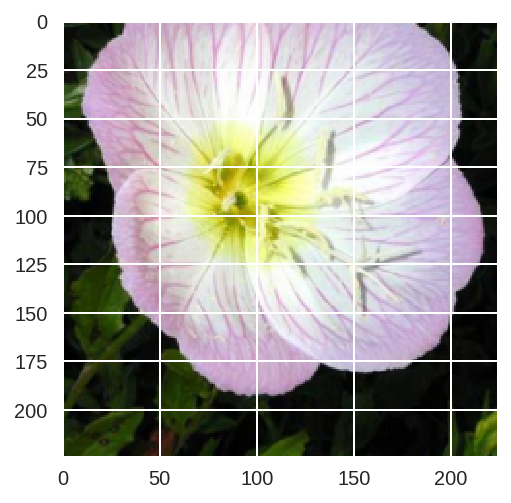

In [0]:
# Checking the above function
imshow(image)

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    # Moving the model to CPU
    model.cpu()
       
    # Put the model in evaluation mode
    model.eval()
    
    image = process_image(image_path)
    image = image.unsqueeze(0)
    
    # Turn off gradients
    with torch.no_grad():
        output = model.forward(image)
        ps = torch.exp(output)
        
        # Calculate the topk probabilties, default is top 5
        top_p, top_class = ps.topk(topk)
        classes_probability = []
        
        for label in top_class.numpy()[0]:
            classes_probability.append(list(model.class_to_idx.keys())[list(model.class_to_idx.values()).index(label)])
    return top_p.numpy()[0], classes_probability

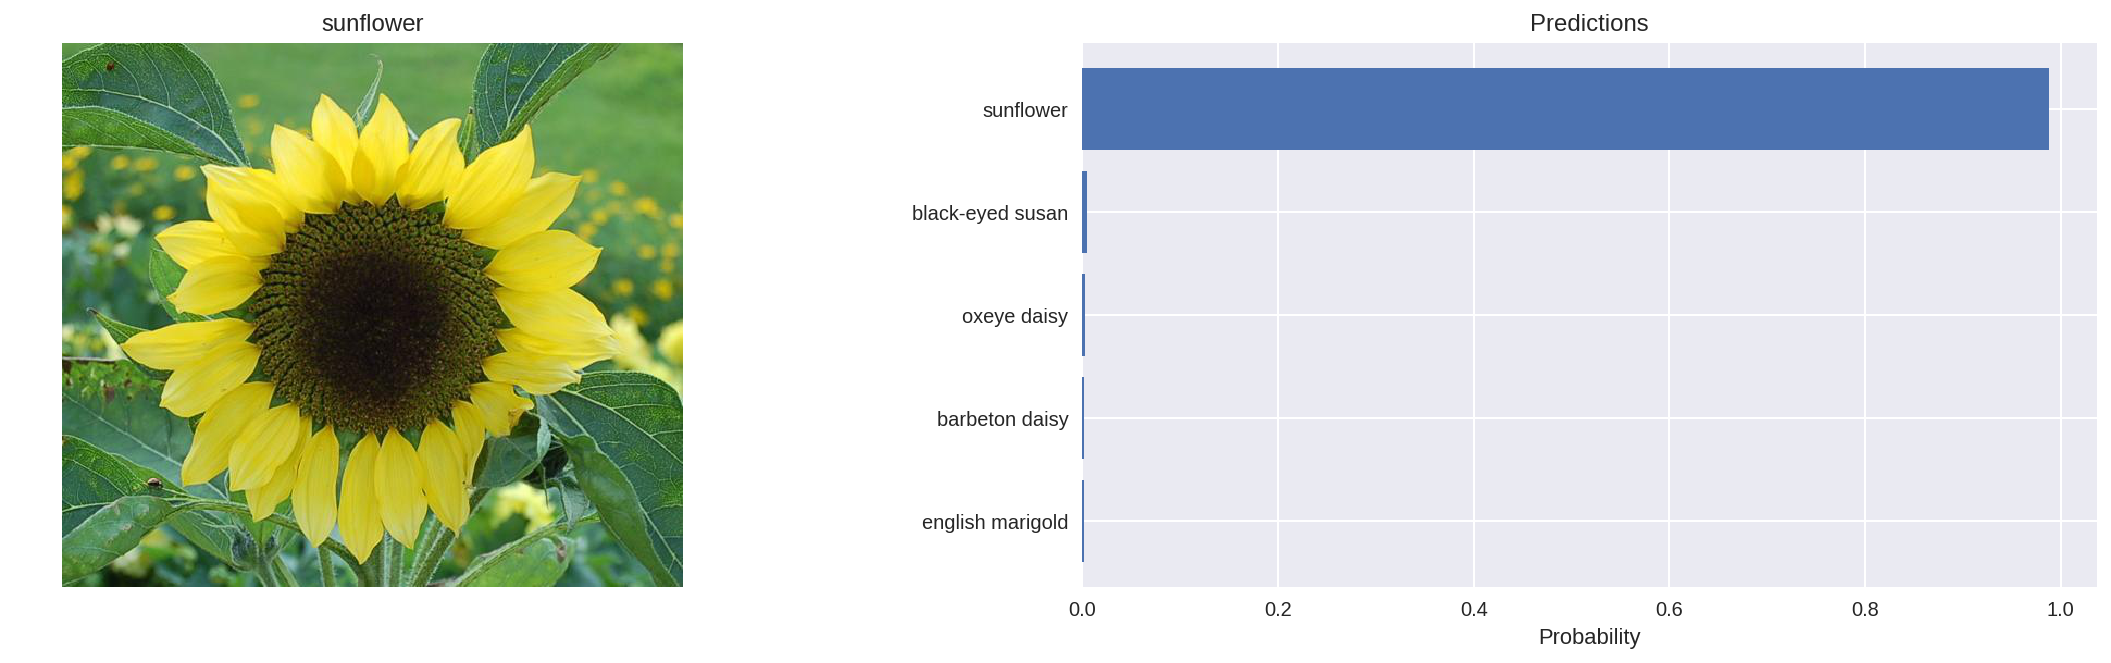

In [0]:
# TODO: Display an image along with the top 5 classes

# Loading an example image
image = 'flowers/test/54/image_05402.jpg'

# True label
true_label = cat_to_name['54']

# Calculing the topk probabilities, default top 5
top_p, top_classes = predict(image, model)

# Empty list to store the predicted labels
labels = []
for classes in top_classes:
    labels.append(cat_to_name[classes])

# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

# Test Image
ax1.set_title(true_label)
ax1.imshow(Image.open(image))
ax1.axis('off')

# Top 5 predictions
ax2.set_title('Predictions')
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(labels)
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
ax2.barh(np.arange(5), top_p, xerr=0, align='center')

plt.show()